In [1]:
from fytok.Tokamak import Tokamak

2023-12-11 12:23:12,167 [    spdm]     INFO: 
###################################################################################################

    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU (Institute of Plasma Physics Chinese Academy of Sciences)
            
 url: https://gitee.com/openfusion/fytok_tutorial 
      https://github.com/fusion-yun/fytok_tutorial

 version = alpha  (spdm=beta extension=0.2.2.dev19+g14adade.d20231205, imas_version=v3_38_1_dirty)

 Run by salmon at 2023-12-11T12:23:11.907820.
 Job ID: fytok_salmon_surface_8892

###################################################################################################



In [2]:
tok = Tokamak("mdsplus:///home/salmon/workspace/fytok_data/mdsplus/~t/?enable=efit_east", device="east", shot=70754)

2023-12-11 12:23:14,521 [    spdm]     INFO: Load module spdm.plugins.data.plugin_xml


In [3]:
tok.refresh(time=5.0)

2023-12-11 12:23:17,857 [    spdm]     INFO: Load module fytok.plugins.equilibrium.fy_eq
2023-12-11 12:23:17,859 [    spdm]     INFO: Initialize module fytok.modules.Wall 
2023-12-11 12:23:17,862 [    spdm]     INFO: Initialize module fytok.modules.TF 
2023-12-11 12:23:17,865 [    spdm]     INFO: Initialize module fytok.modules.Magnetics 
2023-12-11 12:23:17,868 [    spdm]     INFO: Initialize module fytok.modules.PFActive 
2023-12-11 12:23:17,871 [    spdm]     INFO: Initialize module fytok.plugins.equilibrium.FyEqAnalyze 
2023-12-11 12:23:17,940 [    spdm]     INFO: Load module spdm.plugins.data.plugin_mdsplus
2023-12-11 12:23:17,944 [    spdm]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/plugins/data/plugin_mdsplus.py:118:get_tree: Open MDSplus Tree [efit_east] shot=70754
2023-12-11 12:23:17,990 [    spdm]     INFO: Execute module fytok.plugins.equilibrium.FyEqAnalyze
2023-12-11 12:23:17,993 [    spdm]     INFO: Initialize module fytok.modules.CoreProfiles 
2023-12-11 12:

2023-12-11 12:23:19,984 [    spdm]     INFO: Load module spdm.mesh.mesh_rectangular
2023-12-11 12:23:20,013 [    spdm]  WARNING: /home/salmon/workspace/fytok/SpDM/python/spdm/data/HTree.py:368:_as_child: psi!=grid/psi
2023-12-11 12:23:20,090 [    spdm]     INFO: Initialize module fytok.modules.Interferometer 
2023-12-11 12:23:20,115 [    spdm]     INFO: Initialize module fytok.modules.DatasetFAIR 
2023-12-11 12:23:20,117 [    spdm]     INFO: Load module spdm.view.view_matplotlib


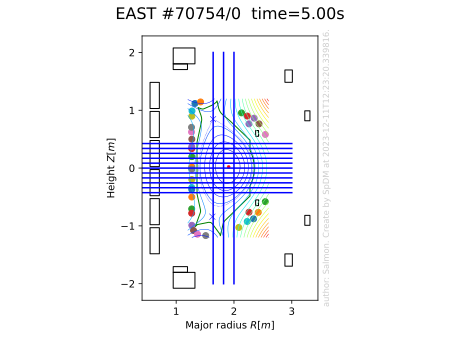

In [4]:
display(tok)

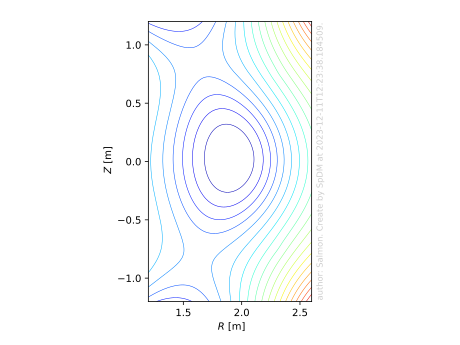

In [5]:
tok.equilibrium.time_slice.current.profiles_2d.psi

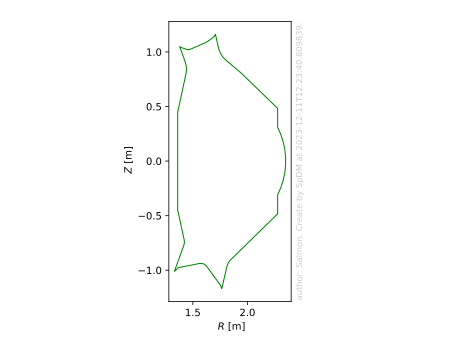

In [6]:
tok.wall

In [ ]:
tok.pf_active

In [ ]:
tok.magnetics

In [ ]:
from spdm.view import View as sp_view

fig=sp_view.display(tok)